In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import gpytorch
from gpytorch import kernels, likelihoods
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import tqdm
import utils as utils

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

from src.fair import run, get_params
from src.preprocessing.glob import load_emissions_dataset, load_response_dataset
from src.structures import Scenario, ScenarioDataset

<IPython.core.display.Javascript object>

In [35]:
import iris

In [36]:
cubes = iris.load('../data/inputs_abrupt-4xCO2.nc')

In [64]:
cubes[0].data

masked_array(data=[4368.559, 4368.559, 4368.559, 4368.559, 4368.559,
                   4368.559, 4368.559, 4368.559, 4368.559, 4368.559,
                   4368.559, 4368.559, 4368.559, 4368.559, 4368.559,
                   4368.559, 4368.559, 4368.559, 4368.559, 4368.559,
                   4368.559, 4368.559, 4368.559, 4368.559, 4368.559,
                   4368.559, 4368.559, 4368.559, 4368.559, 4368.559,
                   4368.559, 4368.559, 4368.559, 4368.559, 4368.559,
                   4368.559, 4368.559, 4368.559, 4368.559, 4368.559,
                   4368.559, 4368.559, 4368.559, 4368.559, 4368.559,
                   4368.559, 4368.559, 4368.559, 4368.559, 4368.559,
                   4368.559, 4368.559, 4368.559, 4368.559, 4368.559,
                   4368.559, 4368.559, 4368.559, 4368.559, 4368.559,
                   4368.559, 4368.559, 4368.559, 4368.559, 4368.559,
                   4368.559, 4368.559, 4368.559, 4368.559, 4368.559,
                   4368.559, 4368.

In [14]:
inputs = xr.open_dataset('../data/inputs_abrupt-4xCO2.nc').compute()

In [56]:
input_abrupt4x = load_emissions_dataset('../data/inputs_abrupt-4xCO2.nc')

In [62]:
1190 / 4

297.5

In [57]:
input_abrupt4x

<xarray.Dataset>
Dimensions:  (time: 500)
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 ... 493 494 495 496 497 498 499 500
Data variables:
    CO2      (time) float32 1.19e+03 1.19e+03 1.19e+03 ... 1.19e+03 1.19e+03
    SO2      (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    CH4      (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    BC       (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

In [3]:
input_abrupt4x = load_emissions_dataset('../data/inputs_abrupt-4xCO2.nc')
output_abrupt4x = load_response_dataset('../data/outputs_abrupt-4xCO2.nc')
# Fill in missing output values with nans
output_abrupt4x = output_abrupt4x.reindex(dict(time=list(range(1, 501))), fill_value=np.nan)

In [4]:
weights = np.cos(np.deg2rad(output_abrupt4x.lat))
global_CO2 = input_abrupt4x.CO2
global_tas = output_abrupt4x.tas.weighted(weights).mean(['lat', 'lon', 'member'])

In [5]:
xr_input = input_abrupt4x
xr_output = output_abrupt4x

# Extract time steps array
time = xr_input.time.values

# Extract cumulative emissions
cum_CO2_emissions = xr_input.CO2.values
cum_emissions = cum_CO2_emissions

# Compute emissions
CO2_emissions = np.append(cum_CO2_emissions[0], np.diff(cum_CO2_emissions))
CH4_emissions = np.zeros_like(CO2_emissions)
SO2_emissions = np.zeros_like(CO2_emissions)
BC_emissions = np.zeros_like(CO2_emissions)
emissions = np.stack([CO2_emissions, CH4_emissions, SO2_emissions, BC_emissions])

# Compute average temperature anomaly
weights = np.cos(np.deg2rad(xr_output.lat))
tas = xr_output.tas.weighted(weights).mean(['lat', 'lon', 'member']).data

# Create scenario
abrupt4x = Scenario(name='abrupt-4xCO2',
                    timesteps=torch.from_numpy(time).float(),
                    emissions=torch.from_numpy(emissions).float().T,
                    tas=torch.from_numpy(tas).float())

In [49]:
# import fit_GP as plaingp
# test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical']}}
# test_data = plaingp.make_data(test_cfg)
# test_scenario = test_data.scenarios[0]

In [50]:
# base_kwargs = utils.get_fair_params()
# res = fair.run(time=test_scenario.full_timesteps.numpy(),
#                emission=test_scenario.full_emissions.T.numpy(),
#                base_kwargs=base_kwargs)

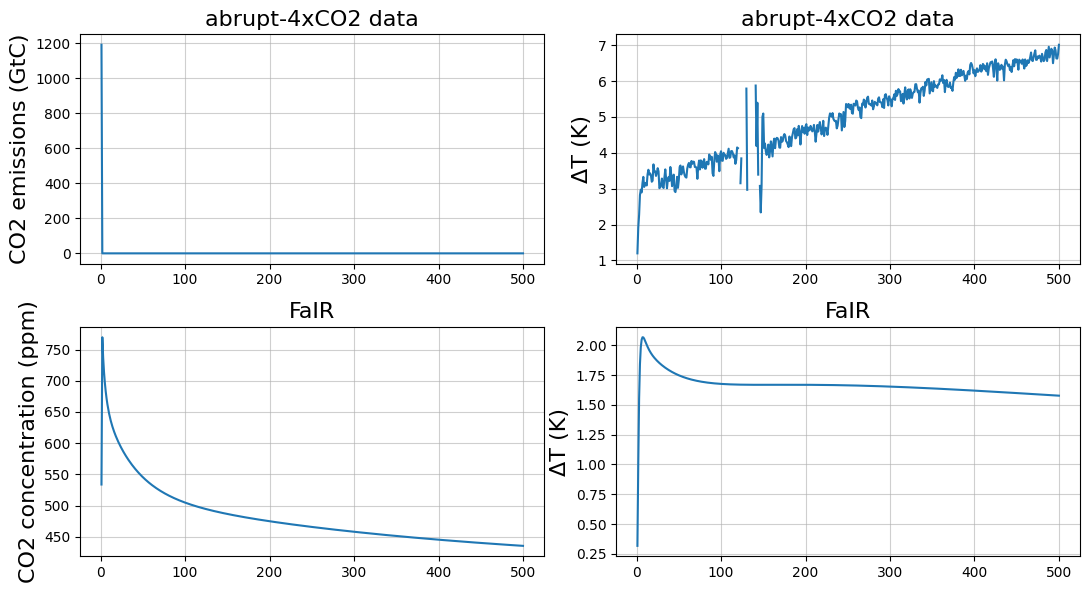

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(11, 6))
fontsize = 16
ax[0, 0].plot(abrupt4x.timesteps, abrupt4x.emissions[:, 0])
ax[0, 0].grid(alpha=0.6)
# ax[0, 0].set_xlabel("Time", fontsize=fontsize)
ax[0, 0].set_ylabel("CO2 emissions (GtC)", fontsize=fontsize)
ax[0, 0].set_title("abrupt-4xCO2 data", fontsize=fontsize)

ax[0, 1].plot(abrupt4x.timesteps, abrupt4x.tas)
ax[0, 1].grid(alpha=0.6)
# ax[0, 1].set_xlabel("Time", fontsize=fontsize)
ax[0, 1].set_ylabel("ΔT (K)", fontsize=fontsize)
ax[0, 1].set_title("abrupt-4xCO2 data", fontsize=fontsize)

ax[1, 0].plot(abrupt4x.timesteps, res['C'][0])
ax[1, 0].grid(alpha=0.6)
# ax[1, 0].set_xlabel("Time", fontsize=fontsize)
ax[1, 0].set_ylabel("CO2 concentration (ppm)", fontsize=fontsize)
ax[1, 0].set_title("FaIR", fontsize=fontsize)

ax[1, 1].plot(abrupt4x.timesteps, res['T'])
ax[1, 1].grid(alpha=0.6)
# ax[1, 1].set_xlabel("Time", fontsize=fontsize)
ax[1, 1].set_ylabel("ΔT (K)", fontsize=fontsize)
ax[1, 1].set_title("FaIR", fontsize=fontsize)

plt.tight_layout()
plt.show()

In [7]:
import src.fair as fair

base_kwargs = utils.get_fair_params()
res = fair.run(time=abrupt4x.full_timesteps.numpy(),
               emission=abrupt4x.full_emissions.T.numpy(),
               base_kwargs=base_kwargs)
# tas = scenario.trim_hist(res['T'])

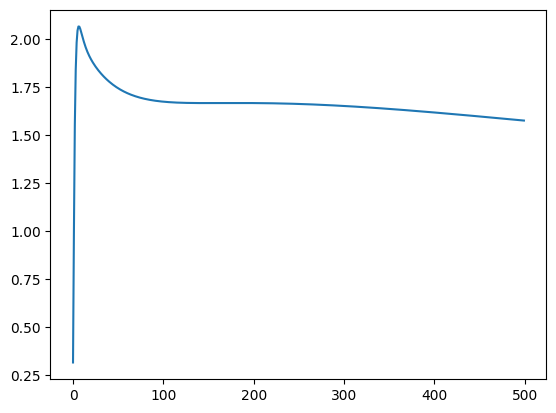

In [12]:
plt.plot(res['T'])

In [13]:
base_kwargs = utils.get_fair_params()
d = base_kwargs['d']
q = base_kwargs['q']

forcing_kernel = kernels.MaternKernel(nu=1.5, ard_num_dims=4, active_dims=[1, 2, 3, 4])
forcing_kernel = kernels.ScaleKernel(forcing_kernel)

kernel = forcing_kernel

In [14]:
train_keys = ['historical']
inputs = {key: load_emissions_dataset(f'../data/inputs_{key}.nc') for key in train_keys}
outputs = {key: load_response_dataset(f'../data/outputs_{key}.nc') for key in train_keys}

def make_scenario(name, hist_scenario=None):
    time, _, emission, tas = utils.extract_arrays(inputs[name], outputs[name])
    scenario = Scenario(name=name,
                        timesteps=torch.from_numpy(time).float(),
                        emissions=torch.from_numpy(emission).float().T,
                        tas=torch.from_numpy(tas).float(),
                        hist_scenario=hist_scenario)
    return scenario

hist_scenario = make_scenario('historical')
# ssps = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
ssps = []
scenarios = {'historical': hist_scenario}
for name in ssps:
    scenario = make_scenario(name, hist_scenario)
    scenarios[name] = scenario
    
train_scenarios = ScenarioDataset(scenarios=list([scenarios[key] for key in train_keys]),
                                  hist_scenario=hist_scenario)
test_scenarios = ScenarioDataset(scenarios=[abrupt4x],
                                 hist_scenario=None)

In [22]:
likelihood = likelihoods.GaussianLikelihood()
model = ThermalBoxesGP(scenario_dataset=train_scenarios,
                       kernel=kernel,
                       likelihood=likelihood,
                       q=q, d=d,
                       internal_variability=True)

In [23]:
model.kernel.outputscale = 0.546323
model.kernel.base_kernel.lengthscale = torch.tensor([0.986062, 3.141069, 0.030032, 0.02148])
likelihood.noise = 0.005084
model.OU_kernel.outputscale = 0.025922

In [24]:
model = model.eval()

with torch.no_grad():
    test_posterior = model(test_scenarios)
    noisy_pred = likelihood(test_posterior)

/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:25: UserWarning: gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense
  warnings.warn("gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense")


In [25]:
test_times = test_scenarios.timesteps
test_tas = test_scenarios.tas

test_tas_fair = model._compute_mean(test_scenarios)

with torch.no_grad():
    test_prior = model.forward(test_scenarios)
    noisy_test_prior = likelihood(test_prior)

prior_mean = noisy_test_prior.mean + test_tas_fair
prior_lb, prior_ub = noisy_test_prior.confidence_region()
prior_lb = prior_lb.detach() + test_tas_fair
prior_ub = prior_ub.detach() + test_tas_fair

posterior_mean = noisy_pred.mean + test_tas_fair
posterior_lb, posterior_ub = noisy_pred.confidence_region()
posterior_lb = posterior_lb.detach() + test_tas_fair
posterior_ub = posterior_ub.detach() + test_tas_fair

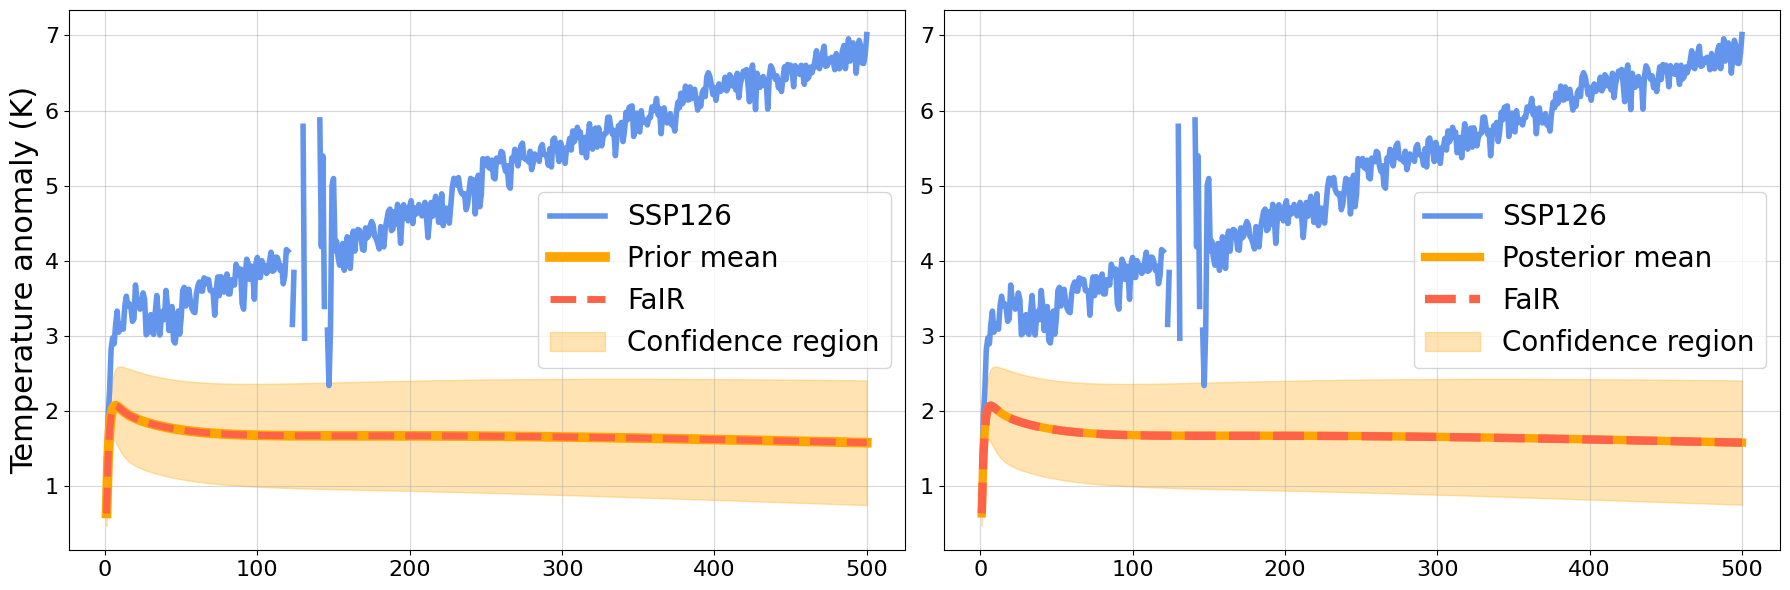

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP126')
ax[0].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[0].plot(test_times, prior_mean, color='orange', lw=7, label='Prior mean')
ax[0].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=5, label='FaIR')
ax[0].fill_between(test_times, prior_lb, prior_ub, alpha=0.3, color='orange', label='Confidence region')
ax[0].tick_params(labelsize=16)
ax[0].grid(alpha=0.5)
ax[0].legend(fontsize=20)

ax[1].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP126')
# ax[1].set_ylabel('Temperature anomaly (K)', fontsize=20)
ax[1].plot(test_times, posterior_mean, color='orange', lw=6, label='Posterior mean')
ax[1].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=6, label='FaIR')
ax[1].fill_between(test_times, posterior_lb, posterior_ub, alpha=0.3, color='orange', label='Confidence region')
ax[1].tick_params(labelsize=16)
ax[1].grid(alpha=0.5)
ax[1].legend(fontsize=20)

plt.tight_layout()
plt.show()